In [1]:
%matplotlib inline
from __future__ import division
import pandas as pd
import random as rnd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
#Use the same random seed to make results replicable
rnd.seed(1235822231)

# About the paper 

The [paper](https://www.scienceopen.com/document/review?3&id=7a235c56-a1da-498f-98ef-6fa16c8fd2f0&review=9870bf08-c06e-403a-85ba-774e27cdb520) presents an analysis of data from radiobiological experiments carried out in a laboratory. Out of the data, there is the suspicion that some of the results may be biased or fabricated. The authors used long term data produced in the same laboratory along with data from other sources that use the same techniques as benchmark data and make comparisons with the suspected data. 

The techniques used looked into two possible sources of suspicion, first the ratio of the distances between triplicate samples assuming that a way to fabricate the data is to pre-select and average and then fixing the other to samples to achieve that average. The authors checked how likely it is that the averages are present in the triplicate samples using a Poisson - binomial distribution test. Furthermore, they draw some statistical analysis of the likelihood that the mid ratios are close or exactly 0.5; however, we believe that a more thorough analysis of this observation is required. 

Finally, the authors analyze the rightmost digit in search for possible fabrication making the same analysis as in other papers. Even though this is an interesting metric, we don't find it justifiable to think that according to the methodologies used for counting this would an issue since all the triplicate data is an integer. At the end of the paper the authors carried out a  $\chi^2$ permutation test assess the goodness of fit of the terminal digits, a test motivation is not clear in the paper. 

The main critique of the paper, also acknowledged by the authors, is that the sample size of the suspected data is significantly larger than the benchmark data; hence, the total population data is dominated by the suspected data. Moreover, the data provided was already categorized between the suspicious and the benchmark, thus biasing the direction of the test towards "proving a set of data might be biased" instead of a more transparent analysis of finding suspicious data in a pool. In other words, it presupposes that the data from the RTS already doesn't follow the same patterns as the benchmark data. From this point of view, it would have been better to provide the information and have executed the test without a hypothesis about the suspected data.  

Nevertheless, we believe the authors made an interesting contribution by providing the scientific community with methods to potentially test for data fabrication in radiobiological data. As a review good practice, we carried out some analysis of the provided data to check for possible unintended errors in the data processing. Also, calcultion of the ratios in 2 ways, testing the upper value of the ratios and also the lower value. In order to also test the asssumption of uniformity of the ratios, we have created synthetic information drawn from Poisson random number generators. 

In the following sections of the review, we analyze the data quality and wether the samples sizes are actually as reported, corroborated the assumption that the ratios of the benchmark data indeed may follow a uniform distribution and included an alternative anaysis of the suspected data using [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test) comparing against an uniform distribution. The synthetic Poisson data was also evaluated using the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test).   

Moreover, as an alternative measure, we made a 2-Sample [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test) to test whether the suspected data and the benchmark data could have come from the same CDF without making any assumptions about the underlying CDF. 

# Data Loading and count check.
This portion of the code is intended to load the datafiles into dataframes to better handling and join. Also, will present the verification of the results from Table 2 presented in the [paper](https://www.scienceopen.com/document/review?3&id=7a235c56-a1da-498f-98ef-6fa16c8fd2f0&review=9870bf08-c06e-403a-85ba-774e27cdb520). 

In the following lines of code we have dropped the columns not relevant for the analysis, the final outcome are dataframes for each data sample and a merged dataframe with all the samples. 

In [22]:
#Colony dataframes
bishayee_colony = pd.read_excel("Bishayee Colony Counts 10.27.97-3.8.01.xlsx", skiprows=2,na_values=" ")
outside3_colony = pd.read_excel("Outside Lab 3.Colony Counts.2.4.10-5.21.12.xlsx", skiprows=1)
others_colony = pd.read_excel("Other Investigators in Lab.Colony Counts.4.23.92-11.27.02.xlsx", skiprows=1)
    #Clean up of the colony data
bishayee_colony["Inv"] = "Z"
bishayee_colony.drop('ISOTOPE', axis=1, inplace=True)
bishayee_colony2 = bishayee_colony.iloc[:,[0,1,6,2,3,4,5]]
bishayee_colony2.columns
bishayee_colony2.rename(columns={'Bate # B0/B00':'Batch'},inplace = True)
bishayee_colony2.drop('Batch', axis=1, inplace=True)
bishayee_colony2.drop("Date",axis =1,inplace=True)
others_colony2 = others_colony.rename(columns={'Bates # B00 or B0':'Batch'})
others_colony2.drop('Batch', axis=1, inplace=True)
others_colony2.drop("Date",axis =1,inplace=True)
outside3_colony["Inv"] = "O"
outside3_colony2=outside3_colony.iloc[:,[0,5,1,2,3,4]]
outside3_colony2.rename(columns={'date':'Date','c1':'col1','c2':'col2','c3':'col3'},inplace = True)
outside3_colony2.drop("Date",axis =1,inplace=True)
df_total = [bishayee_colony2,others_colony2,outside3_colony2]
merged_colony_data = pd.concat(df_total)    
#Coulter dataframes
bishayee_coulter = pd.read_excel("Bishayee Coulter Counts.10.20.97-7.16.01.xlsx", skiprows=1)
others_coulter = pd.read_excel("Other Investigators in Lab.Coulter Counts.4.15.92-5.21.05.xlsx", skiprows=1)
    #This data file had no header, introduced manually
outside1_coulter = pd.read_excel("Outside Lab 1.Coulter Counts.6.7.91-4.9.99.xlsx")
outside1_coulter.columns = ["Experiment", "C1", "C2", "C3","Average","Date"]
outside2_coulter = pd.read_excel("Outside Lab 2.Coulter Counts.6.6.08-7.7.08.xlsx", skiprows=1)
    #Clean up of the coulter data 
bishayee_coulter2 = bishayee_coulter.drop('Bates', axis=1)
bishayee_coulter2["Inv"] = "Z"
bishayee_coulter2 = bishayee_coulter2.iloc[:,[0,5,1,2,3,4]]
bishayee_coulter2.rename(columns={'Count 1':'col1','Count 2':'col2','Count 3':'col3'},inplace=True)
bishayee_coulter2.drop("Date",axis =1,inplace=True)
outside1_coulter2 = outside1_coulter.drop('Experiment', axis = 1)
outside1_coulter2["Inv"] = "O1"
outside1_coulter2 = outside1_coulter2.iloc[:,[4,5,0,1,2,3]]
outside1_coulter2.rename(columns={'C1':'col1','C2':'col2','C3':'col3'},inplace=True)
outside1_coulter2.drop("Date",axis =1,inplace=True)
outside2_coulter2 = outside2_coulter.rename(columns={'Count 1':"col1",'Count 2':"col2",'Count 3':"col3"})
outside2_coulter2["Inv"] = "O2"
outside2_coulter2 = outside2_coulter2.iloc[:,[0,5,1,2,3,4]]
outside2_coulter2.drop("Date",axis =1,inplace=True)
others_coulter2 = others_coulter.drop('Bates No.', axis = 1)
others_coulter2.rename(columns={'Coul 1':'col1','Coul 2':'col2','Coul 3':'col3','Investigator':'Inv'},\
                       inplace=True)
others_coulter2 = others_coulter2.iloc[:,[0,5,1,2,3,4]]
others_coulter2.drop("Date",axis =1,inplace=True)
df_total_coulter = [bishayee_coulter2,others_coulter2,outside1_coulter2,outside2_coulter2]
merged_coulter_data = pd.concat(df_total_coulter)

The following step is to verify the magnitudes of the data in the sets for the coulter and the colony. From the description of the experimental set-up, it seems that the count of the cells using the coulter and the colony count are actually individual experiments with different methods.

In [3]:
print 'Total number of colony data triplets  ' + str(merged_colony_data.index.size)
print 'Total number of suspected colony data triplets  ' + str(bishayee_colony2.index.size)
print 'Total number of others colony data triplets  ' + str(others_colony2.index.size)
print 'Total number of outside lab 3 colony data triplets  ' + str(outside3_colony2.index.size)

Total number of colony data triplets  2033
Total number of suspected colony data triplets  1362
Total number of others colony data triplets  621
Total number of outside lab 3 colony data triplets  50


The raw total number of samples doesn't coincide with the numbers in the [paper](https://www.scienceopen.com/document/review?3&id=7a235c56-a1da-498f-98ef-6fa16c8fd2f0&review=9870bf08-c06e-403a-85ba-774e27cdb520). Furthermore, the labeling of the outside labs is not consistent. It looks like the authors labeled the outside colony counts at lab1 when indeed is lab3. 

The following step is to eliminate incomplete triples and drop the na rows and check again against the authors' table. The designation (AD) is used to differentiate the data after drop. The total counts after the drop are as follows:

In [23]:
merged_colony_data.replace(r'\s*',np.nan, regex=True)
merged_colony_data=merged_colony_data.dropna()
merged_colony_data.reset_index(drop=True)
print 'Total number of colony data triplets (AD) ' + str(merged_colony_data.index.size) 
bishayee_colony2.replace(r'\s*',np.nan, regex=True)
bishayee_colony2 = bishayee_colony2.dropna()
bishayee_colony2.reset_index(drop=True)
print 'Total number of suspected colony data triplets (AD) ' + str(bishayee_colony2.index.size)
others_colony2.replace(r'\s*',np.nan, regex=True)
others_colony2 = others_colony2.dropna()
others_colony2.reset_index(drop=True)
print 'Total number of others colony data triplets (AD) ' + str(others_colony2.index.size)
outside3_colony2.replace(r'\s*',np.nan, regex=True)
outside3_colony2 = outside3_colony2.dropna()
outside3_colony2.reset_index(drop=True)
print 'Total number of outside lab 3 colony data triplets (AD) ' + str(outside3_colony2.index.size)

Total number of colony data triplets (AD) 2008
Total number of suspected colony data triplets (AD) 1361
Total number of others colony data triplets (AD) 597
Total number of outside lab 3 colony data triplets (AD) 50


The same data clean up and count of the the triplets is performed with the coulter data, the resulting counts are as follows:

In [26]:
print 'Total number of coulter data triplets  ' + str(merged_coulter_data.index.size)
print 'Total number of suspected coulter data triplets  ' + str(bishayee_coulter2.index.size)
print 'Total number of others coulter data triplets  ' + str(others_coulter2.index.size)
print 'Total number of outside lab1 data triplets  ' + str(outside1_coulter2.index.size)
print 'Total number of outside lab2 data triplets  ' + str(outside2_coulter2.index.size)

Total number of coulter data triplets  2873
Total number of suspected coulter data triplets  1727
Total number of others coulter data triplets  929
Total number of outside lab1 data triplets  97
Total number of outside lab2 data triplets  120


In [27]:
merged_coulter_data.replace(r'\s*',np.nan, regex=True)
merged_coulter_data = merged_coulter_data.dropna()
merged_coulter_data.reset_index(drop=True)
print 'Total number of coulter data triplets (AD) ' + str(merged_coulter_data.index.size)
bishayee_coulter2.replace(r'\s*',np.nan, regex=True)
bishayee_coulter2 = bishayee_coulter2.dropna()
bishayee_coulter2.reset_index(drop=True)
print 'Total number of suspected coulter data triplets (AD) ' + str(bishayee_coulter2.index.size)
others_coulter2.replace(r'\s*',np.nan, regex=True)
others_coulter2 = others_coulter2.dropna()
others_coulter2.reset_index(drop=True)
print 'Total number of others coulter data triplets (AD) ' + str(others_coulter2.index.size)
outside1_coulter2.replace(r'\s*',np.nan, regex=True)
outside1_coulter2 = outside1_coulter2.dropna()
outside1_coulter2.reset_index(drop=True)
print 'Total number of outside lab1 data triplets (AD) ' + str(outside1_coulter2.index.size)
outside2_coulter2.replace(r'\s*',np.nan, regex=True)
outside2_coulter2 = outside2_coulter2.dropna()
outside2_coulter2.reset_index(drop=True)
print 'Total number of outside lab2 data triplets (AD) ' + str(outside2_coulter2.index.size)

Total number of coulter data triplets (AD) 2873
Total number of suspected coulter data triplets (AD) 1727
Total number of others coulter data triplets (AD) 929
Total number of outside lab1 data triplets (AD) 97
Total number of outside lab2 data triplets (AD) 120


The analysis of the complete triples yields a discrepancy when compared to Table 2. The results of the count are consistent for "total" in the fourth column. The RTS (suspected) colony counts, and the outside lab3 (labeled in the [paper](https://www.scienceopen.com/document/review?3&id=7a235c56-a1da-498f-98ef-6fa16c8fd2f0&review=9870bf08-c06e-403a-85ba-774e27cdb520) as lab1) are equal. The only discrepancy is the count for the other's colony count; however, the discrepancy is very small i.e., 8 triplets. 

In the case of the coulter counts there is no discrepancy with respect to the No. complete, the others, lab2 and lab1 (labeled in the [paper](https://www.scienceopen.com/document/review?3&id=7a235c56-a1da-498f-98ef-6fa16c8fd2f0&review=9870bf08-c06e-403a-85ba-774e27cdb520) as lab3) are consistent with Table 2. The discrepancy appears in the RTS (suspected) sample, but again it is a comparatively small differnece i.e., 11. 

It is worth nothing that the authors dropped triplets with gap $\ge$ 2, this is not completely explained in the [paper](https://www.scienceopen.com/document/review?3&id=7a235c56-a1da-498f-98ef-6fa16c8fd2f0&review=9870bf08-c06e-403a-85ba-774e27cdb520) and it is only mentioned in a footnote in Table 2. If there are issues with the gaps, they are expected to show up in the ratio of the distances between the samples in the forthcoming analysis.  

## Calculation of the distance ratios

A function is used to take a dataframe and add columns with the values of the distance ratios between the samples, even though the [paper](https://www.scienceopen.com/document/review?3&id=7a235c56-a1da-498f-98ef-6fa16c8fd2f0&review=9870bf08-c06e-403a-85ba-774e27cdb520) only mentions a single ratio we tested the distances from the mid value in both directions. The proceedure for the calculations is as follows: 

$$
\begin{align}
\text{sort} (\hat{t})\\
\\
LowerRatio = \frac{\hat{t}(2) - \hat{t}(1)}{\hat{t}(3) - \hat{t}(1)}\\
\\
UpperRatio = \frac{\hat{t}(3) - \hat{t}(2)}{\hat{t}(3) - \hat{t}(1)}
\end{align}
$$

The final output of the function are two numpy vectors with the Upper Ratio (UR) and Lower Ratio (LR) values

If any ratio is NaN because all the numbers are the same then it gets dropped when calculating UR and LR. After this process the total amount of triplets gets counted again to review if the counts still match. The test is labeld as Valid Rarios counts (VR)

In [28]:
#Print empirical CDF plot from a data vector x. 
def cdf_plot(x):
    x_data = np.sort(x)
    y_data = 1. * np.arange(len(x_data))/(len(x_data)-1)
    plt.plot(x_data, y_data)

In [29]:
def DistanceRatioCalculation(data_frame,startIndex=1):
    '''
    Calculates the ratio of the distance between a triplet sample.
    The startIndex is needed because in most of the dataFrame the columns 
    start in the first second column (column 1 here), but not in all cases.
    $$
    \begin{align}
    \text{sort} (\hat{t})\\
    \\
    LowerRatio = \frac{\hat{t}(2) - \hat{t}(1)}{\hat{t}(3) - \hat{t}(1)}\\
    \\
    UpperRatio = \frac{\hat{t}(3) - \hat{t}(2)}{\hat{t}(3) - \hat{t}(1)}
    \end{align}
    $$
    '''
    if not isinstance(data_frame, pd.DataFrame):
        print 'Wrong data type, dataframe expected'
    else:
        df_ur = np.ones(len(data_frame))
        df_lr = np.ones(len(data_frame))
        for i in range(0,len(data_frame)):
            temp_array = np.ones(3)
            for k in range(0,3):
                temp_array[k] = data_frame.iloc[i,(startIndex+k)]
            temp_array = np.sort(temp_array)
            df_lr[i] = (temp_array[1]-temp_array[0])/(temp_array[2]-temp_array[0])
            df_ur[i] = (temp_array[2]-temp_array[1])/(temp_array[2]-temp_array[0])
            if (df_lr[i]) == 0 and (df_ur[i]) != 1:
                print "data issues, the distances are not complementary"
        df_ur = df_ur[~np.isnan(df_ur)] 
        df_lr = df_lr[~np.isnan(df_lr)] 
        df_ur= np.squeeze(df_ur)  
        df_lr= np.squeeze(df_lr) 
    return df_lr, df_ur

In [30]:
merged_colony_data_d = DistanceRatioCalculation(merged_colony_data)
print 'Total number of colony data triplets (VR) ' + str(len(merged_colony_data_d[0]))
bishayee_colony2_d = DistanceRatioCalculation(bishayee_colony2)
print 'Total number of suspected colony data triplets (VR) ' + str(len(bishayee_colony2_d[0]))
others_colony2_d = DistanceRatioCalculation(others_colony2)
print 'Total number of others colony data triplets (VR) ' + str(len(others_colony2_d[0]))
outside3_colony2_d = DistanceRatioCalculation(outside3_colony2)
print 'Total number of outside lab 3 colony data triplets (VR) ' + str(len(outside3_colony2_d[0]))

Total number of colony data triplets (VR) 2005
Total number of suspected colony data triplets (VR) 1360
Total number of others colony data triplets (VR) 595
Total number of outside lab 3 colony data triplets (VR) 50


In [31]:
merged_coulter_data_d = DistanceRatioCalculation(merged_coulter_data)
print 'Total number of coulter data triplets (VR) ' + str(len(merged_coulter_data_d[0]))
bishayee_coulter2_d = DistanceRatioCalculation(bishayee_coulter2)
print 'Total number of suspected coulter data triplets (VR) ' + str(len(bishayee_coulter2_d[0]))
others_coulter2_d = DistanceRatioCalculation(others_coulter2)
print 'Total number of others coulter data triplets (VR) ' + str(len(others_coulter2_d[0]))
outside1_coulter2_d = DistanceRatioCalculation(outside1_coulter2)
print 'Total number of outside lab1 data triplets (VR) ' + str(len(outside1_coulter2_d[0]))
outside2_coulter2_d = DistanceRatioCalculation(outside2_coulter2)
print 'Total number of outside lab2 data triplets (VR) ' + str(len(outside2_coulter2_d[0]))

Total number of coulter data triplets (VR) 2873
Total number of suspected coulter data triplets (VR) 1727
Total number of others coulter data triplets (VR) 929
Total number of outside lab1 data triplets (VR) 97
Total number of outside lab2 data triplets (VR) 120


## Final analysis of the data count

The final counts of the valid ratios to be statistically analyzed are sufficiently similar to the reported values in Table 2, thus, we are confindent in using the data in the forthcoming tests.

# Testing of the uniformity assumption about the benchmark data

The authors made several assumptions about the underlying structure of the data and perform a set of tests. Even though we believe the results are good, we propose an alternative set of tests to further confirm those assumptions. The tests carried out are as follows: 

* Create a synthetic set of data from a Poisson random variable to test uniformity of the distance ratios. 

* Perform a KS test of the data comparing with a uniformn distribution, both for the grouped benchmarck data, individally for each dataset and for the suspected data. 

After calculating the different ratios, it is possible to make a visual inspection of the data as in Figures 1(a) and 2(b) in the paper. 

### Test of Poisson



In [11]:
def CreatePoissonDataFrame(data):
    '''
    Input: data: Dataframe which we assume it has a column average
    The method returns a dataframe with  three columns ('col1', 'col2',
    'col3') where each element was obtained from independent poisson random
    variable with mean equal to the original entry in the 'average'  column
    in the starting	dataframe.
    '''
    columnSize=data.shape[0]
    col1=np.zeros(columnSize)
    col2=np.zeros(columnSize)
    col3=np.zeros(columnSize)    
    for i in range(0,columnSize):
        aux = np.random.poisson(data.iloc[i]['average'], 3)
        col1[i]=aux[0]
        col2[i]=aux[1]
        col3[i]=aux[2]
    dataToReturn = pd.DataFrame(
    {'col1': col1,     'col2': col2,
     'col3': col3}, columns=['col1','col2','col3'])
    return dataToReturn

I create the dataframes for the poisson below for all possibilities of cooulter/colony. I change the column name from 'Average' to 'average' for the datasets who needed. 

In [12]:
merged_coulter_data=merged_coulter_data.rename(columns={'Average':'average'})
others_coulter2=others_coulter2.rename(columns={'Average':'average'})
outside1_coulter2=outside1_coulter2.rename(columns={'Average':'average'})
outside2_coulter2=outside2_coulter2.rename(columns={'Average':'average'})
mer3_col=CreatePoissonDataFrame(merged_colony_data)
mer3_col2=CreatePoissonDataFrame(bishayee_colony2)
mer3_ocol=CreatePoissonDataFrame(others_colony2)
mer3_oucol=CreatePoissonDataFrame(outside3_colony2)
mer3_coul=CreatePoissonDataFrame(merged_coulter_data)
mer3_ocoul=CreatePoissonDataFrame(others_coulter2)
mer3_oucoul=CreatePoissonDataFrame(outside1_coulter2)
mer3_oucoul2=CreatePoissonDataFrame(outside2_coulter2)

We calculate the distance ratios for all the datasets created above

In [13]:
mer3_col_ratio=DistanceRatioCalculation(mer3_col,0)
mer3_col2_ratio=DistanceRatioCalculation(mer3_col2,0)
mer3_ocol_ratio=DistanceRatioCalculation(mer3_ocol,0)
mer3_oucol_ratio=DistanceRatioCalculation(mer3_oucol,0)
mer3_coul_ratio=DistanceRatioCalculation(mer3_coul,0)
mer3_ocoul_ratio=DistanceRatioCalculation(mer3_ocoul,0)
mer3_oucoul_ratio=DistanceRatioCalculation(mer3_oucoul,0)
mer3_oucoul2_ratio=DistanceRatioCalculation(mer3_oucoul2,0)

Now i create a function to see the comparison against the cdf of a uniform.

In [14]:
def VisualInspectionAgainstUnif(array_Data):
    sample_uniform = np.random.uniform(0,1,1000)
    cdf_plot(array_Data)
    cdf_plot(sample_uniform)

Visual Inspection of lower ratios.

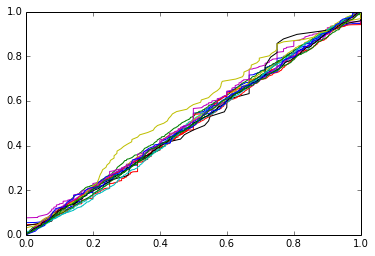

In [15]:
VisualInspectionAgainstUnif(mer3_col_ratio[0])
VisualInspectionAgainstUnif(mer3_col2_ratio[0])
VisualInspectionAgainstUnif(mer3_ocol_ratio[0])
VisualInspectionAgainstUnif(mer3_oucol_ratio[0])
VisualInspectionAgainstUnif(mer3_coul_ratio[0])
VisualInspectionAgainstUnif(mer3_ocoul_ratio[0])
VisualInspectionAgainstUnif(mer3_oucoul_ratio[0])
VisualInspectionAgainstUnif(mer3_oucoul2_ratio[0])

Visual Inspection of upper ratios

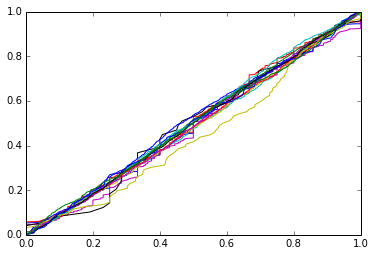

In [16]:
VisualInspectionAgainstUnif(mer3_col_ratio[1])
VisualInspectionAgainstUnif(mer3_col2_ratio[1])
VisualInspectionAgainstUnif(mer3_ocol_ratio[1])
VisualInspectionAgainstUnif(mer3_oucol_ratio[1])
VisualInspectionAgainstUnif(mer3_coul_ratio[1])
VisualInspectionAgainstUnif(mer3_ocoul_ratio[1])
VisualInspectionAgainstUnif(mer3_oucoul_ratio[1])
VisualInspectionAgainstUnif(mer3_oucoul2_ratio[1])

In [17]:
def uniformkspermutation(data,permutations,sample_size = 100):
    """
    This function is designed to take a set of data and perform a KS statistic permutation test 
    against an uniform distribution sample of size 10000. The output is an array of sixe trials of KS statistics. 
    
    inputs: data is the total population of data
    permutations: is the number of permutations 
    sample_size: is the sample size of the data draw for each permutation
    """    
    result_array = np.ones(permutations)
    for t in range(0,permutations):
        permutationsample = ReturnSample(data,sample_size)
        test_result =stats.kstest(permutationsample, 'uniform')
        result_array[t] = test_result[0]
    return np.squeeze(result_array)

### Figure 1(b) check. 

Visual inspection

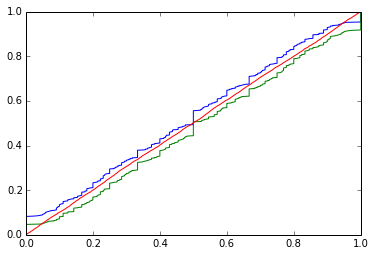

In [18]:
sample_uniform = np.random.uniform(0,1,10000)
cdf_plot(np.concatenate((others_colony2_d[0],outside3_colony2_d[0])))
cdf_plot(np.concatenate((others_colony2_d[1],outside3_colony2_d[1])))
cdf_plot(sample_uniform)

In [19]:
#change var naming
def ReturnSample(l,n):
    indexes=rnd.sample(range(1,len(l)),n)  
    return np.asarray([l[i] for i in indexes])

### Permutation test (?)

How can we check what level of the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test) statistic is surprising, a first approach is to make a lot of KS calculations from samples of the benchmark data.

The 95% percentile is 0.2
The 95% percentile is 0.2


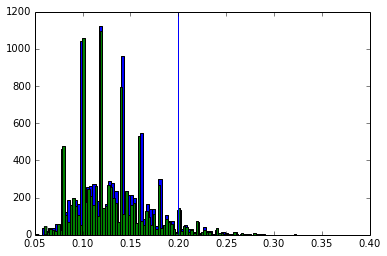

In [20]:
benchmark_sample = np.concatenate((others_colony2_d[0],outside3_colony2_d[0]));
uniform_test = uniformkspermutation(benchmark_sample,10000,sample_size = 50);
x = plt.hist(uniform_test, bins = 100)
x = plt.axvline(x=np.percentile(uniform_test, 95), color = 'b')
print 'The 95% percentile is ' + str(np.percentile(uniform_test, 95))
benchmark_sample = np.concatenate((others_colony2_d[1],outside3_colony2_d[1]));
uniform_test = uniformkspermutation(benchmark_sample,10000,sample_size = 50);
x = plt.hist(uniform_test, bins = 100)
x = plt.axvline(x=np.percentile(uniform_test, 95), color = 'b')
print 'The 95% percentile is ' + str(np.percentile(uniform_test, 95))

### Figure 1(a) check. 

Same as before but applied to the suspicous data.

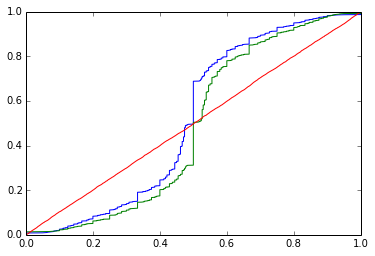

In [21]:
sample_uniform = np.random.uniform(0,1,10000)
cdf_plot(bishayee_colony2_d[0])
cdf_plot(bishayee_colony2_d[1])
cdf_plot(sample_uniform)

The 95% percentile is 0.293333333333
The 95% percentile is 0.291052631579


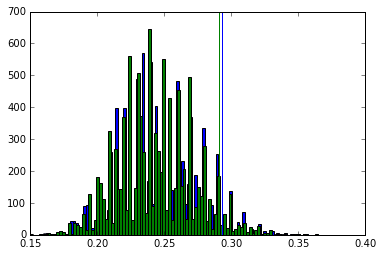

In [22]:
uniform_test = uniformkspermutation(bishayee_colony2_d[0],10000,sample_size = 100);
x = plt.hist(uniform_test, bins = 100)
x = plt.axvline(x=np.percentile(uniform_test, 95), color = 'b')
print 'The 95% percentile is ' + str(np.percentile(uniform_test, 95))
uniform_test = uniformkspermutation(bishayee_colony2_d[1],10000,sample_size = 100);
x = plt.hist(uniform_test, bins = 100)
x = plt.axvline(x=np.percentile(uniform_test, 95), color = 'g')
print 'The 95% percentile is ' + str(np.percentile(uniform_test, 95))

## [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test) permutation test implementation:

Considering that the authors decided to test against the uniform distribution, we performed a permutation test for the KS statistic. In this test, we analyze whether the difference in the distribution of the ratio from the suspected data to the uniform distribution is "surprising." The reason we perform this test is because deviation from the uniform distribution is used as a justification for finding the person suspicious.

In [23]:
def kstestpermutation(susData,allData,permutations):
    """
    To do this, we first calculate the difference between the suspected person's ratio distribution and 
    the uniform distribution's cumulative density function using the Kolmogorov-Smirnov test.

    Then we lump together all the data of the suspected person, other people in his lab and the outside 
    scientists. From this larger population we draw a sample of the same size as that of the suspected 
    person's data. We then calcualte the difference between the randomly drawn sample and the unform 
    distribution via the KS test.     
    
    The result of the KS test for each permutation is stored in an array. 
    The frequency distribution of the KS statistic is then plotted and we then find the probability that 
    the difference that we observed could have been observed by chance.
    """
    
    #Step 1. Difference from suspected data
    orig_Diff=stats.kstest(susData, 'uniform', N=1000)
    #Step 2. Permute overall population and blabla
    real_Diff=uniformkspermutation(allData,permutations,len(susData))
    #Step 3. Plot the differences.
    test1_plot= plt.figure()
    plt.hist(real_Diff, bins = 100)
    plt.axvline(x=orig_Diff[0], color = 'r')
    #Step 4. Be surprised "obtain p-value".
    aux_array=real_Diff[np.where(real_Diff<orig_Diff[0])]
    val_less_than_orig=len(aux_array)
    aux=(val_less_than_orig*1.0)/(len(real_Diff)*1.0)
    return (1-aux)

0.0

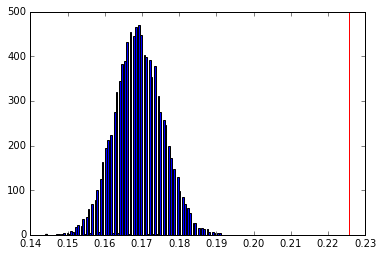

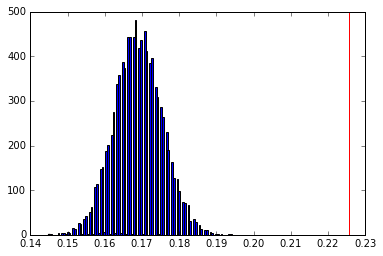

In [24]:
#Lower Ration analysis. 
kstestpermutation(bishayee_colony2_d[0],merged_colony_data_d[0],10000)
#Upper Ratio analysis 
kstestpermutation(bishayee_colony2_d[1],merged_colony_data_d[1],10000)
#Fix the return value of the p-value 

0.0

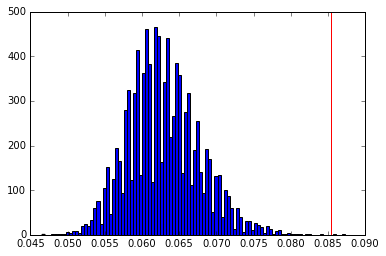

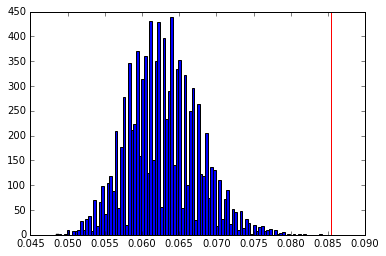

In [25]:
# lower coulter ration
kstestpermutation(bishayee_coulter2_d[0],merged_coulter_data_d[0],10000)
#upper coulter ratio
kstestpermutation(bishayee_coulter2_d[1],merged_coulter_data_d[1],10000)

### Results 

The KS statistic is way in the tails of the distribution.

## Two sample KS test. 

We have selected to make a 2S KS in order to avoid using assumptions about the underlying uniform distribution

The implementation of the ks-test for two samples in scipy is implemented as follows: 

```
data1 = np.sort(data1)
    data2 = np.sort(data2)
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    data_all = np.concatenate([data1, data2])
    cdf1 = np.searchsorted(data1, data_all, side='right') / (1.0*n1)
    cdf2 = np.searchsorted(data2, data_all, side='right') / (1.0*n2)
    d = np.max(np.absolute(cdf1 - cdf2))
    # Note: d absolute not signed distance
    en = np.sqrt(n1 * n2 / float(n1 + n2))
    try:
        prob = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)
    except:
        prob = 1.0

    return Ks_2sampResult(d, prob)
```

If you see, it assummes that the two samples make up the whole distribution space. Hence we need to be careful on how we provide the data to not over-specify the information. 

In [26]:
benchmark_sample_colony = np.concatenate((others_colony2_d[0],outside3_colony2_d[0]));
benchmark_sample_coulter = np.concatenate((others_coulter2_d[0],outside1_coulter2_d[0],outside2_coulter2_d[0]));

In [27]:
def ReturnSampleAndComplement(l,n):
    """
    Missing docstring, pending. 
    """
    indexes=rnd.sample(range(1,len(l)),n)  
    return (np.asarray([l[i] for i in indexes]),np.asarray([l[i] for i in range(1,n) if i not in indexes]))

In [28]:
def ks2samplepermutation(data_suspected, data_all, trials):
    """
    This function is designed to take a set of the data "data_benchmark" and perform a KS statistic permutation test 
    against a larger sample to determine wether "data_benchmark" could have been produced from data with the same
    statistical nature as the "data_test"
    """
    result_array = np.ones(trials)
    for t in range(0,trials):
        permutationsample = ReturnSampleAndComplement(data_all,len(data_suspected))
        sample_1 = permutationsample[0]
        sample_2 = permutationsample[1]
        result = stats.ks_2samp(sample_1, sample_2)
        result_array[t] = result[0]
    return np.squeeze(result_array)     

In [29]:
def ks2stestpermutation(susData,otherData,allData,permutations):
    """
    Missing docstring, pending. 
    """
    #Step 1. Difference from suspected data
    orig_Diff=stats.ks_2samp(susData,otherData)
    #Step 2. Permute overall population and blabla
    real_Diff= ks2samplepermutation(susData,allData, permutations)
    #Step 3. Plot the differences.
    test1_plot= plt.figure()
    plt.hist(real_Diff, bins = 100)
    plt.axvline(x=orig_Diff[0], color = 'r')
    #Step 4. Be surprised "obtain p-value".
    aux_array=real_Diff[np.where(real_Diff<orig_Diff[0])]
    val_less_than_orig=len(aux_array)
    aux=(val_less_than_orig*1.0)/(len(real_Diff)*1.0)
    return (1-aux)

0.0
0.0


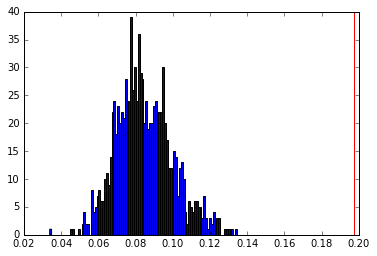

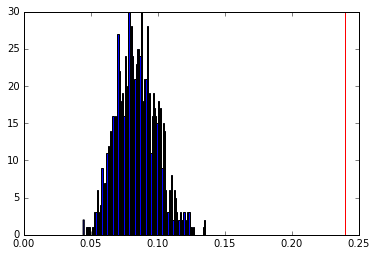

In [ ]:
#Lower Ratio analysis
print ks2stestpermutation(bishayee_colony2_d[0],benchmark_sample_colony,merged_colony_data_d[0],1000)
#Upper ratio analysis
print ks2stestpermutation(bishayee_colony2_d[1],benchmark_sample_colony,merged_colony_data_d[1],1000)

In [ ]:
#Lower Ratio analysis
print ks2stestpermutation(bishayee_coulter2_d[0],benchmark_sample_coulter,merged_coulter_data_d[0],1000)
#Upper ratio analysis
print ks2stestpermutation(bishayee_coulter2_d[1],benchmark_sample_coulter,merged_coulter_data_d[1],1000)

# Final Remarks